# Multiclass classification

In this notebook we will explore how multiclass classification works. We will use the **[One vs All](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest)** technique. We will follow the algorithms and notations used in the course ["Learning from Data" on the edX platform](https://www.edx.org/course/learning-data-introductory-machine-caltechx-cs1156x-0).

Although this is not part of the problem set, I was inspired to look into multiclass classification by a discussion on the forums.

## Problem

We have a target function $f$ that takes a point $(x_1, x_2)$ from the domain $X = [-1,1] \times [-1,1]$ and labels it according to which [quadrant](https://en.wikipedia.org/wiki/Quadrant_(plane_geometry) it is in.

For example

- $(0.7, 0.15)$ is in quadrant $1$,
- $(-0.7, 0.15)$ is in quadrant $2$,
- $(-0.7, -0.15)$ is in quadrant $3$ and
- $(0.7, 0.15)$ is in quadrant $4$.

For the points above the **class labels** are then $y = 1, 2, 3, 4$ respectively, so we have four classes.

The following is an example for a possible data set:

```
         x1        x2    y
0  0.468318 -0.658732  4.0
1  0.424253  0.776762  1.0
2  0.304160  0.094324  1.0
3 -0.200936  0.367361  2.0
4  0.544131 -0.153533  4.0
```




## Task

Our task is to find a hypothesis $g$ that approximates the target function $f$, i.e. we will train a classifier that takes a point and assigns it to one of the four classes.



## 0. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# https://stackoverflow.com/questions/9777783/suppress-scientific-notation-in-numpy-when-creating-array-from-nested-list
np.set_printoptions(suppress=True)

## 1. Generate training set

The first step is to generate a training set of $N = 100$ points. We will label the points depending on the sign of $x_1$ and $x_2$ which tells us in which quadrant a point $(x_1, x_2$) is.

         x1        x2    y
0 -0.126710 -0.470406  3.0
1 -0.340435 -0.087862  3.0
2 -0.099544 -0.016919  3.0
3  0.407312  0.217345  1.0
4  0.432286  0.639332  1.0


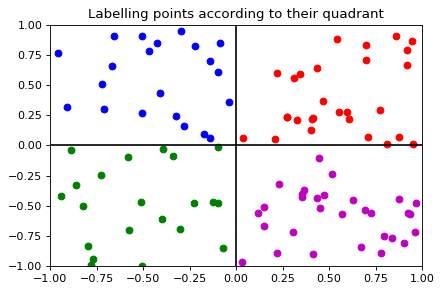

In [2]:
# Choose 100 random points in the box [-1,1] x [-1,1] as training points
N = 100
x1 = np.random.uniform(-1,1,N)
x2 = np.random.uniform(-1,1,N)


# target function
def label(x1, x2):
    '''
    - Takes coordinates x1 and x2.
    - Returns the quadrant in which a point (x1,x2) is, e.g.
      (0.7, 0.15) is in quadrant 1,
      (-0.7, 0.15) is in quadrant 2
      (-0.7, -0.15) is in quadrant 3
      (0.7, 0.15) is in quadrant 4
    '''
    if x1 >= 0 and x2 >= 0:
        return 1
    elif x1 < 0 and x2 >= 0:
        return 2
    elif x1 < 0 and x2 < 0:
        return 3
    else:
        return 4

    
# target function vectorized so we can pass vectors x1 and x2
# https://stackoverflow.com/questions/7701429/efficient-evaluation-of-a-function-at-every-cell-of-a-numpy-array
# https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.vectorize.html
f = np.vectorize(label)


# label points
y = f(x1, x2)


# create data table and print first 5 rows for illustration
# we will use a pandas dataframe
data = np.array([x1, x2, y]).T
df = pd.DataFrame(data, columns=['x1', 'x2','y'])
print(df.head(5))


# plot points and their classification
fig0 = plt.figure(0, dpi = 80)
plt.plot(x1[y==1], x2[y==1], 'ro')
plt.plot(x1[y==2], x2[y==2], 'bo')
plt.plot(x1[y==3], x2[y==3], 'go')
plt.plot(x1[y==4], x2[y==4], 'mo')

# coordinate axes
plt.plot([-1,1], [0,0], 'k')
plt.plot([0,0], [-1,1], 'k')

plt.title('Labelling points according to their quadrant')
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()


# save figure
fig0.savefig('figures/target_function_distribution.png')

## 2. One vs All strategy

We will follow the One vs All strategy described [here on Wikipedia](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest). Note though that we will not use the label $y = 0$ but instead the label $y = -1$. 

Throughout the course we used the labels $y = +1$ and $y = -1$, and not $y = +1$ and $y = 0$! Consider for example the *Perceptron Learning Algorithm (PLA)*. If you examine how PLA works it becomes clear that it is necessary to use the labels $y = +1$ and $y = -1$ because it relies on determining the sign. The same applies to *linear regression* and *logistic regression* where we also used the labels $y = +1$ and $y = -1$.

Below is a quote from the [Wikipedia page](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest) describing One vs All (with the labels modified to $y = +1$ and $y = -1$):

**Inputs:**

- $L$, a learner (training algorithm for binary classifiers)
- samples $X$
- labels $\mathbf{y}$ where $y_i \in \{1, … K \}$ is the label for the sample $X_i$

**Output:**

- a list of classifiers $g_k$ for $k \in \{1, …, K \}$

**Procedure:**

For each $k \in \{1, …, K \}$

- Construct a new label vector $\mathbf{b}$ where $b_i = 1$ if $y_i = k$ and $b_i = -1$ otherwise
- Apply $L$ to $X, b$ to obtain $g_k$


Making decisions means applying all classifiers to an unseen sample $x$ and predicting the label $k$ for which the corresponding classifier reports the highest **confidence score**:

$\hat{y} = \underset{k \in \{1, …, K \}}{\text{argmax } }  g_k(x)$

The Wikipedia article also describes two problems that are associated with this heuristic. First, the scale of the confidence may differ between the binary classifiers. Second, the number of samples that are labelled as $y = +1$ and $y = -1$ respectively in the training set may be balanced. However, the distribution for $b_i = +1$ and $b_i = -1$ that the binary classifiers see is unbalanced because we typically have more samples laballed as $b_i = -1$ than $b_i = +1$ (see also the plots below which make this obvious).

## 3. Choice of binary classifiers

### Sign function

Suppose we chose the sign function as binary classifiers $g_k(\mathbf{x}) = \text{sign}(\mathbf{w}_k^T \mathbf{x})$. This classifier just returns $-1$ or $+1$ depending on whether it thinks a point's true label is $b_i = -1$ or $b_i = +1$, i.e. whether it thinks a point belongs to its class.

Now, let's consider a point $\mathbf{x}$. The classifiers $g_1, g_2, g_3$ and $g_4$ might return the following:

- $g_1(\mathbf{x}) = -1$
- $g_2(\mathbf{x}) = -1$
- $g_3(\mathbf{x}) = 1$
- $g_4(\mathbf{x}) = -1$

Only classifier $g_3$ classifies the point as $+1$ and therefore says that it belongs to its class, namely $3$. The remaining classifiers $g_1, g_2$ and $g_4$ classify it as $-1$, and state that the point does not belong to class $1, 2$ and $4$ respectively. We would finally classify the point as belonging to class $3$. 

However, consider another point $\mathbf{x}$ for which the classifiers return the following:
- $g_1(\mathbf{x}) = -1$
- $g_2(\mathbf{x}) = 1$
- $g_3(\mathbf{x}) = 1$
- $g_4(\mathbf{x}) = -1$

Now suddenly, both classifier $g_2$ and $g_3$ state that the point belongs to their class respectively, and we cannot say  which class the point belongs to. To resolve this **ambiguity** we will instead use the logistic function as classifier.

### Logistic function

We choose the logistic function $g_k(\mathbf{x}) = \frac{1}{1 + \exp(-\mathbf{w}^T_k \mathbf{x})}$. The output $g_k(\mathbf{x})$ can be interpreted as the probability that $\mathbf{x}$ has the label $y = +1$.

Suppose the four classifiers yield the following output:

- $g_1(\mathbf{x}) = 0.03$
- $g_2(\mathbf{x}) = 0.10$
- $g_3(\mathbf{x}) = 0.001$
- $g_4(\mathbf{x}) = 0.99$

We interpret this as follows. 

- $g_1$ states that $\mathbf{x}$ belongs to class $1$ with probability $0.03$, 
- $g_2$ states that $\mathbf{x}$ belongs to class $2$ with probability $0.10$,
- $g_3$ states that $\mathbf{x}$ belongs to class $3$ with probability $0.001$,
- $g_4$ states that $\mathbf{x}$ belongs to class $4$ with probability $0.99$. 

In this case our final output would be that $\mathbf{x}$ belongs to class $4$ because $g_4$ returns the highest probability. The logistic function does not suffer from the ambiguity we discussed before as it is unlikely that two classifiers returns the exact same probability.

## 4. Logistic regression

We will use a nonlinear transformation transformation

$\phi(\mathbf{x}) = \mathbf{z} = (1, z_1, z_2, ..., z_{\tilde{d}})$ , 

concretely

$\phi(\mathbf{x}) = \mathbf{z} = (1,   x_1,       x_2,     x_1^2,   x_1 x_2, 
  x^2_2, x_1^3, x^2_1 x_2, x_1 x_2^2,     x_2^3,
  x_1^4, x_1^3 x_2, x_1^2 x_2^2, x_1 x_2^3, x_2^4)^T
$

Our classifier now takes vectors $\mathbf{z}$:

$g_k(\mathbf{z}) = \text{sign}(\mathbf{w}_k^T \mathbf{z})$

Note that our transformed data point $\mathbf{z}$ is a vector of length $15$, which means that our weight vector $\mathbf{w}$ has $15$ components, so we can work with $15$ parameters $w_0, w_1, w_2, ..., w_{14}$. The reason is that we need a decision boundary that can successfully separate e.g. the points in the first quadrant from all the other points, and we have seen from the exercises that this model can produce quite flexible decision boundaries.

In [3]:
# feature matrix Z
def get_feature_matrix(x1, x2):
    '''
    - Takes vectors x1 and x2.
    - Returns feature matrix Z.
    '''
    Z = np.array([np.ones(N), x1, x2,
                 x1**2, x1*x2, x2**2,
                 x1**3, x1**2 * x2, x1* x2**2, x2**3,
                  x1**4, x1**3 * x2, x1**2 * x2**2, x1 * x2**3, x2**4]).T
    return Z

Let's get the **feature matrix** $Z$ by plugging in the vectors for $x_1$ and $x_2$.

In [4]:
# feature matrix Z
Z = get_feature_matrix(x1, x2)

We implement the **logistic function** and our **binary classifier**. To evaluate $g_k(\mathbf{z}) = \text{sign}(\mathbf{w}_k^T \mathbf{z})$ on each point $\mathbf{z}$ we can use the matrix vector product between the feature matrix $Z$ and the weight vector $\mathbf{w}_k^T$. 

In [5]:
def logistic(s):
    return np.exp(s) / (1 + np.exp(s))

# classifier: logistic function
def g(Z, w_tilde):
    return logistic(np.dot(Z, w_tilde))

### Stochastic gradient descent

To train our classifier $g_k(\mathbf{z}) = \text{sign}(\mathbf{w}_k^T \mathbf{z})$ we have to determine the weight vector $\mathbf{w}_k$. We will use Stochastic Gradient Descent (SGD).

In [6]:
def logistic_regression(X, y_f):
    '''
    - Takes a feature matrix X, i.e. rows in X have the form
      (1, x1, x2, ..., xN) where x1 to xN are features, e.g. 
      they could be coordinates in the transformed space Z.
      In our example we have the feature matrix Z:
      
      Z = np.array([np.ones(N), x1, x2,
                 x1**2, x1*x2, x2**2,
                 x1**3, x1**2 * x2, x1* x2**2, x2**3,
                  x1**4, x1**3 * x2, x1**2 * x2**2, x1 * x2**3, x2**4]).T
                  
    - Returns weight vector w_g by using Stochastic Gradient Descent (SGD)
      with Logistic Regression
    '''
    
    # Run logistic regression
    eta = 0.01                          # learning rate
    
    num_parameter = X.shape[1]          # number of parameters of hypothesis
                                        # which is also the dimension of the transformed Z space,
                                        # in our case 15
            
    w_g = np.zeros(num_parameter)       # weight vector for hypothesis g
                                        # # initialize weights for hypothesis with zeros

    
    # start iterations
    for t in range(10**5):

        # create permutation of data points
        indices = list(range(N))
        np.random.shuffle(indices)
        w_old = w_g

        # for each epoch
        for index in indices:
            xn = X[index, :]                 # pick a point
            yn = y_f[index]
            delta_w = -yn * xn / (1 + np.exp(yn * np.dot(w_g.T, xn)))
            
            # update w
            w_g = w_g - eta * delta_w

        # after epoch check how much w_g changed
        if np.linalg.norm(w_g - w_old) < 0.01:
            break

    return w_g

## 5.1 Training $g_1$ for $1$ vs $\{2,3,4\}$

For this step we will first create new labels $b_1$ specifically for our classifier $g_1$. If a point $(x_1, x_2)$ is in the first quadrant, then we assign it the label $b_1 = +1$, otherwise if it is outside of the first quadrant we assign the label $b_1 = -1$. Here is an example:

```
         x1        x2   b1
0  0.468318 -0.658732 -1.0
1  0.424253  0.776762  1.0
2  0.304160  0.094324  1.0
3 -0.200936  0.367361 -1.0
4  0.544131 -0.153533 -1.0
```

In this example only the points 1 and 2 are are in the first quadrant and thus are labelled $b_1 = +1$. All other points get the label $b_1 = -1$.

The way we actually do this is by taking the class labels $y$ and checking if $y = 1$, i.e. if a point is labelled as belonging to class 1.

```
         x1        x2    y   b1
0  0.468318 -0.658732  4.0 -1.0
1  0.424253  0.776762  1.0  1.0
2  0.304160  0.094324  1.0  1.0
3 -0.200936  0.367361  2.0 -1.0
4  0.544131 -0.153533  4.0 -1.0
```

The table shows that points 1 and 2 are in class $y = 1$, and are thus labelled $b_1 = +1$. All other points belonging to a different class are labelled $b_1 = -1$.

In [7]:
def get_labels_bi(y, class_label):
    '''
    - Takes vector y containing class labels, e.g. [1, 4, 2, 1, 3] means
      point 0 belongs to class 1,
      point 1 belongs to class 4,
      point 2 belongs to class 2
      point 3 belongs to class 1
      point 4 belongs to class 3
    - parameter class_label
    - Returns new label vector b that contains 1 if a point belongs to class_label, 
      returns -1 otherwise.
    - Example: if class_label = 4, then for y = [1, 4, 2, 1, 3]
      we get b = [-1, 1, -1, -1, -1]
    '''
    if y == class_label:
        return 1
    else:
        return -1

# https://stackoverflow.com/questions/7701429/efficient-evaluation-of-a-function-at-every-cell-of-a-numpy-array
get_labels_bi = np.vectorize(get_labels_bi, otypes=[np.float])

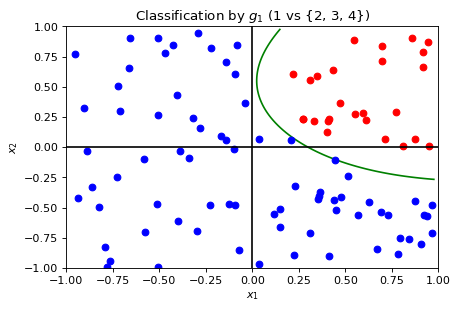

In [8]:
b1 = get_labels_bi(y, 1)
w_tilde_1 = logistic_regression(Z, b1)    # trained classifier
predicted_1 = g(Z, w_tilde_1)             # probability that label b1 = +1

#---------------------------------------

fig1 = plt.figure(1, dpi = 80)
belongs_to_class_1 = predicted_1 > 0.5    # boolean vector

plt.plot(x1[belongs_to_class_1], x2[belongs_to_class_1], 'ro')
plt.plot(x1[~belongs_to_class_1], x2[~belongs_to_class_1], 'bo')

# coordinate axes
plt.plot([-1,1], [0,0], 'k')
plt.plot([0,0], [-1,1], 'k')

#----------------------------------------

# plot decision boundary via a contour plot
# procedure: 
# - points on the decision boundary have a 50% probability of being classified as bi = +1.
# - the logistic function theta(s) = 1/(1 + exp(-s)) has value 0.5 = 50% at s = 0, 
# where s was the dot product (w^T z).
# So we set w^T z = 0.
# If you interpret this as a function beta(z) = w^T z that you set to zero, i.e. beta(z) = 0,
# then this corresponds to a contour plot of the function beta(z) at "height" zero.
boundary = lambda x1, x2, w: w[0]*1 + w[1]*x1 + w[2]*x2 + w[3] *x1**2 + w[4]*x1*x2 + w[5]*x2**2 + w[6] *x1**3 + w[7]*x1**2*x2 + w[8]*x1*x2**2 + w[9]*x2**3 + w[10]*x1**4 + w[11]*x1**3*x2 + w[12]* x1**2 * x2**2   + w[13]* x1 * x2**3    + w[14]* x2**4
u = np.arange(-1.0,1.0,0.02)
X,Y= np.meshgrid(u,u)

beta = boundary(X,Y, w_tilde_1)
CS = plt.contour(X,Y,beta, [0.0], colors = 'g')

#--------------

plt.title('Classification by $g_1$ (1 vs {2, 3, 4})')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()


# save figure
fig1.savefig('figures/1_vs_234.png')

## 5.2 Training $g_2$ for $2$ vs $\{1,3,4\}$

We repeat the steps for class 2, i.e. points in quadrant 2.

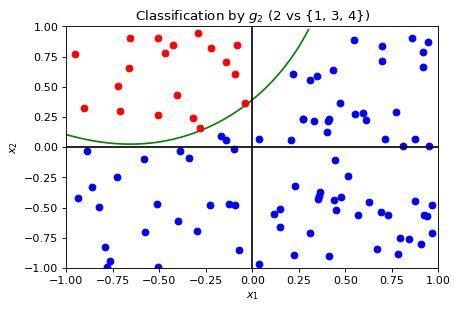

In [9]:
b2 = get_labels_bi(y, 2)
w_tilde_2 = logistic_regression(Z, b2)
predicted_2 = g(Z, w_tilde_2)             # probability that label b2 = +1

#---------------------------------------

fig2 = plt.figure(2, dpi = 80)
belongs_to_class_2 = predicted_2 > 0.5    # boolean vector

plt.plot(x1[belongs_to_class_2], x2[belongs_to_class_2], 'ro')
plt.plot(x1[~belongs_to_class_2], x2[~belongs_to_class_2], 'bo')

# coordinate axes
plt.plot([-1,1], [0,0], 'k')
plt.plot([0,0], [-1,1], 'k')

#----------------------------------------

# plot decision boundary via a contour plot
# procedure: 
# - points on the decision boundary have a 50% probability of being classified as bi = +1.
# - the logistic function theta(s) = 1/(1 + exp(-s)) has value 0.5 = 50% at s = 0, 
# where s was the dot product (w^T z).
# So we set w^T z = 0.
# If you interpret this as a function beta(z) = w^T z that you set to zero, i.e. beta(z) = 0,
# then this corresponds to a contour plot of the function beta(z) at "height" zero.
boundary = lambda x1, x2, w: w[0]*1 + w[1]*x1 + w[2]*x2 + w[3] *x1**2 + w[4]*x1*x2 + w[5]*x2**2 + w[6] *x1**3 + w[7]*x1**2*x2 + w[8]*x1*x2**2 + w[9]*x2**3 + w[10]*x1**4 + w[11]*x1**3*x2 + w[12]* x1**2 * x2**2   + w[13]* x1 * x2**3    + w[14]* x2**4
u = np.arange(-1.0,1.0,0.02)
X,Y= np.meshgrid(u,u)

beta = boundary(X,Y, w_tilde_2)
CS = plt.contour(X,Y,beta, [0.0], colors = 'g')

#--------------

plt.title('Classification by $g_2$ (2 vs {1, 3, 4})')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()


# save figure
fig2.savefig('figures/2_vs_134.png')

## 5.3 Training $g_3$ for $3$ vs $\{1,2,4\}$

We repeat the steps for class 3, i.e. points in quadrant 3.

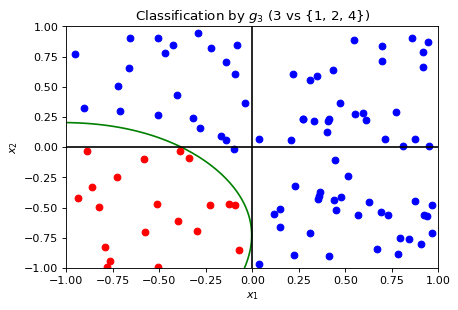

In [10]:
b3 = get_labels_bi(y, 3)
w_tilde_3 = logistic_regression(Z, b3)
predicted_3 = g(Z, w_tilde_3)             # probability that label b3 = +1

#---------------------------------------

fig3 = plt.figure(3, dpi = 80)
belongs_to_class_3 = predicted_3 > 0.5    # boolean vector

plt.plot(x1[belongs_to_class_3], x2[belongs_to_class_3], 'ro')
plt.plot(x1[~belongs_to_class_3], x2[~belongs_to_class_3], 'bo')

# coordinate axes
plt.plot([-1,1], [0,0], 'k')
plt.plot([0,0], [-1,1], 'k')

#----------------------------------------

# plot decision boundary via a contour plot
# procedure: 
# - points on the decision boundary have a 50% probability of being classified as bi = +1.
# - the logistic function theta(s) = 1/(1 + exp(-s)) has value 0.5 = 50% at s = 0, 
# where s was the dot product (w^T z).
# So we set w^T z = 0.
# If you interpret this as a function beta(z) = w^T z that you set to zero, i.e. beta(z) = 0,
# then this corresponds to a contour plot of the function beta(z) at "height" zero.
boundary = lambda x1, x2, w: w[0]*1 + w[1]*x1 + w[2]*x2 + w[3] *x1**2 + w[4]*x1*x2 + w[5]*x2**2 + w[6] *x1**3 + w[7]*x1**2*x2 + w[8]*x1*x2**2 + w[9]*x2**3 + w[10]*x1**4 + w[11]*x1**3*x2 + w[12]* x1**2 * x2**2   + w[13]* x1 * x2**3    + w[14]* x2**4
u = np.arange(-1.0,1.0,0.02)
X,Y= np.meshgrid(u,u)

beta = boundary(X,Y, w_tilde_3)
CS = plt.contour(X,Y,beta, [0.0], colors = 'g')

#--------------

plt.title('Classification by $g_3$ (3 vs {1, 2, 4})')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()


# save figure
fig3.savefig('figures/3_vs_124.png')

## 5.4 Training $g_4$ for $4$ vs $\{1,2,3\}$

We repeat the steps for class 4, i.e. points in quadrant 4.

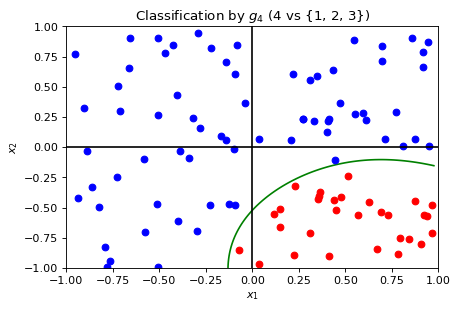

In [11]:
b4 = get_labels_bi(y, 4)
w_tilde_4 = logistic_regression(Z, b4)
predicted_4 = g(Z, w_tilde_4)             # probability that label b4 = +1

#---------------------------------------

fig4 = plt.figure(4, dpi = 80)
belongs_to_class_4 = predicted_4 > 0.5    # boolean vector

plt.plot(x1[belongs_to_class_4], x2[belongs_to_class_4], 'ro')
plt.plot(x1[~belongs_to_class_4], x2[~belongs_to_class_4], 'bo')

# coordinate axes
plt.plot([-1,1], [0,0], 'k')
plt.plot([0,0], [-1,1], 'k')

#----------------------------------------

# plot decision boundary via a contour plot
# procedure: 
# - points on the decision boundary have a 50% probability of being classified as bi = +1.
# - the logistic function theta(s) = 1/(1 + exp(-s)) has value 0.5 = 50% at s = 0, 
# where s was the dot product (w^T z).
# So we set w^T z = 0.
# If you interpret this as a function beta(z) = w^T z that you set to zero, i.e. beta(z) = 0,
# then this corresponds to a contour plot of the function beta(z) at "height" zero.
boundary = lambda x1, x2, w: w[0]*1 + w[1]*x1 + w[2]*x2 + w[3] *x1**2 + w[4]*x1*x2 + w[5]*x2**2 + w[6] *x1**3 + w[7]*x1**2*x2 + w[8]*x1*x2**2 + w[9]*x2**3 + w[10]*x1**4 + w[11]*x1**3*x2 + w[12]* x1**2 * x2**2   + w[13]* x1 * x2**3    + w[14]* x2**4
u = np.arange(-1.0,1.0,0.02)
X,Y= np.meshgrid(u,u)

beta = boundary(X,Y, w_tilde_4)
CS = plt.contour(X,Y,beta, [0.0], colors = 'g')

#--------------

plt.title('Classification by $g_4$ (4 vs {1, 2, 3})')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()


# save figure
fig4.savefig('figures/4_vs_123.png')

## 6. Combining all four binary classifiers

We will now combine all four binary classifiers $g_1, g_2, g_3$ and $g_4$. Each of them returns a probability that serves as a **confidence score** that a point $\mathbf{x}$ belongs to class 1, 2, 3 and 4 respectively. If $g_k$ returns the highest confidence score, then our final verdict is that $\mathbf{x}$ belongs to class $k$.

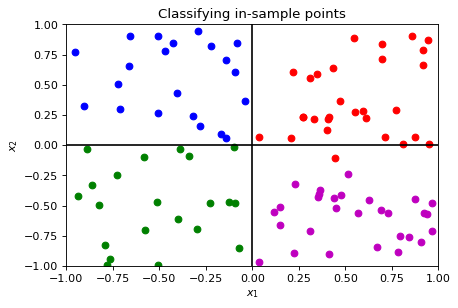

   confidence 1  confidence 2  confidence 3  confidence 4  classification
0      0.011873      0.029254      0.637257      0.253243             3.0
1      0.033342      0.264531      0.569210      0.024879             3.0
2      0.126017      0.209032      0.240193      0.060236             3.0
3      0.849025      0.044704      0.011080      0.064856             1.0
4      0.969477      0.094323      0.001414      0.002672             1.0
5      0.000057      0.000473      0.999597      0.000322             3.0
6      0.000201      0.000151      0.000706      0.999543             4.0
7      0.999932      0.000205      0.000032      0.000022             1.0
8      0.999969      0.000105      0.000016      0.000005             1.0
9      0.000011      0.000073      0.999813      0.000145             3.0

In-sample error E_in =  0.01


In [12]:
# Combine all 4 classifiers
# Use w_tilde_1, w_tilde_2, w_tilde_3, w_tilde_4 to get confidence score
# confidence(x) = logistic(w_k^T x)
# determine which w_tilde_k results in highest confidence score

def confidence(Z, w_tilde_i):
    return logistic(np.dot(Z, w_tilde_i))


# confidence vector confidence_i 
# containing confidence score for each point
confidence_1 = confidence(Z, w_tilde_1)
confidence_2 = confidence(Z, w_tilde_2)
confidence_3 = confidence(Z, w_tilde_3)
confidence_4 = confidence(Z, w_tilde_4)


# all confidence vectors in a single matrix
confidences = np.array([confidence_1, confidence_2, confidence_3, confidence_4]).T


# for each row of the matrix determine the index with the highest
# confidence score.
# The index + 1 is then the class with the highest confidence score.
classifications = 1 + np.argmax(confidences, axis=1)


# classifications
fig5 = plt.figure(5, dpi = 80)
plt.plot(x1[classifications==1], x2[classifications==1], 'ro')
plt.plot(x1[classifications==2], x2[classifications==2], 'bo')
plt.plot(x1[classifications==3], x2[classifications==3], 'go')
plt.plot(x1[classifications==4], x2[classifications==4], 'mo')


# coordinate axes
plt.plot([-1,1], [0,0], 'k')
plt.plot([0,0], [-1,1], 'k')

plt.title('Classifying in-sample points')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()

#-----------

# https://stackoverflow.com/questions/20978757/how-to-append-a-vector-to-a-matrix-in-python
table = np.c_[confidences, classifications]


df = pd.DataFrame(table, columns = ['confidence 1', 'confidence 2', 'confidence 3', 'confidence 4', 'classification'])
print(df.head(10))

print("\nIn-sample error E_in = ", sum(y!=classifications)/ N)


# save figure
fig5.savefig('figures/in_sample_classification.png')

## 7. Classify out of sample points

Finally, we want to test how good our classifier is for out-of sample points. For this we generate `N_test` new points.

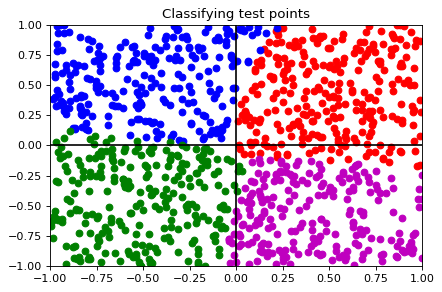

The out-of-sample error is E_out =  0.07


In [13]:
N_test = 1000

x1 = np.random.uniform(-1,1,N_test)
x2 = np.random.uniform(-1,1,N_test)
y_test = f(x1, x2)

Z_test = np.array([np.ones(N_test), x1, x2,
                 x1**2, x1*x2, x2**2,
                 x1**3, x1**2 * x2, x1* x2**2, x2**3,
                  x1**4, x1**3 * x2, x1**2 * x2**2, x1 * x2**3, x2**4]).T

#-------------

def get_classes(Z, y, w_tilde_1, w_tilde_2, w_tilde_3, w_tilde_4):
    '''
    - Takes the feature matrix Z, 
    - labels y (quadrants), 
    - binary classifiers w_tilde_1, w_tilde_2, w_tilde_3, w_tilde_4
    
    - Returns a vector that contains the predicted class
      for each point based on the class with the highest confidence score.
    '''
    confidence_1 = confidence(Z, w_tilde_1)
    confidence_2 = confidence(Z, w_tilde_2)
    confidence_3 = confidence(Z, w_tilde_3)
    confidence_4 = confidence(Z, w_tilde_4)

    confidences = np.array([confidence_1, confidence_2, confidence_3, confidence_4]).T
    classifications = 1 + np.argmax(confidences, axis=1)

    return classifications

#-------------

classifications = get_classes(Z_test, y_test, w_tilde_1, w_tilde_2, w_tilde_3, w_tilde_4)
#print("Z.shape = ", Z.shape)
#print("y.shape = ", y.shape)


# plot of classifications for test set
fig6 = plt.figure(6, dpi = 80)
plt.plot(x1[classifications==1], x2[classifications==1], 'ro')
plt.plot(x1[classifications==2], x2[classifications==2], 'bo')
plt.plot(x1[classifications==3], x2[classifications==3], 'go')
plt.plot(x1[classifications==4], x2[classifications==4], 'mo')

#-------------

# coordinate axes
plt.plot([-1,1], [0,0], 'k')
plt.plot([0,0], [-1,1], 'k')

plt.title('Classifying test points')
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.show()


# out of sample error
E_out = sum(y_test != classifications) / N_test
print("The out-of-sample error is E_out = ", E_out)


# save figure
fig6.savefig('figures/out_of_sample_classification.png')